In [ ]:
!unzip data.zip

Archive:  data.zip
replace data/masks1/00000.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
styles_folder = './data/styles1/'
masks_folder = './data/masks1/'

In [ ]:
#@title
!pip install piq

In [ ]:
#@title
import os
import cv2
from PIL import Image

from piq import ssim
#from piqa import SSIM 


import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset, DataLoader

from torchvision import datasets, transforms
import matplotlib.pyplot as plt
%matplotlib inline
import torch.nn as nn
import torch.nn.functional as F

import cv2
torch.set_printoptions(precision=10)

from IPython.display import display
from PIL import Image




In [ ]:
#@title
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


cpu


# Display Functions

In [ ]:
#@title
# Display results


def display_losses(epoch, total_loss, loss_mask, loss_style, loss_12, loss_13):
    print("Epoch = ", epoch)
    print("Total Loss = {:.3f}".format(total_loss.item()))
    print("Mask Loss = {:.3f}".format(loss_mask.item()))
    print("Style Loss = {:.3f}".format(loss_style.item()))
    print("12 Loss = {:.3f}".format(loss_12.item()))
    print("13 Loss = {:.3f}".format(loss_13.item()))
    print("Same Style Loss = {:.3f}".format(loss_samestyle.item()))
    print("Same mask Loss = {:.3f}".format(loss_samemask.item()))    
    return

def display_epoch_losses(epochs, losses):
    x = list(range(epochs))
    return plt.plot(x,losses)

def display_images(image,mask,recon,flag=0):
    
    image = torch.clamp(image, 0, 1)
    mask = torch.clamp(mask, 0, 1)
    if mask.shape[1] == 1:
        mask = mask.repeat(1,3,1,1)
    recon = torch.clamp(recon, 0, 1)
    
    if flag == 1:
        print("SSIM Score = {:.3f}".format( ssim(mask, recon).item()))
    else:
        print("SSIM Score = {:.3f}".format( ssim(image, recon).item()))
    
    image = transforms.ToPILImage()(image.squeeze())
    mask = transforms.ToPILImage()(mask.squeeze())
    recon = transforms.ToPILImage()(recon.squeeze())
    
    fig =plt.figure(figsize=(5,5))
    fig.add_subplot(1,3,1);plt.imshow(image)
    fig.add_subplot(1,3,2);plt.imshow(mask)
    fig.add_subplot(1,3,3);plt.imshow(recon)

    plt.show()    

    

def display_all(gt_image, out_mask, out_image,
                gt_ss_image, ss_out_mask, ss_out_image,
                gt_sm_image, sm_out_mask, sm_out_image,
                out12_image, out13_image
               ):
    print("Base Image (Image 1)")
    display_images(gt_image, out_mask, out_image)
    
    print("\nSame Style (Image 2)")
    display_images(gt_ss_image, ss_out_mask, ss_out_image)
    
    print("\nSame Mask (Image 3)")
    display_images(gt_sm_image, sm_out_mask, sm_out_image)
    
    print("\nFirst Image style + Second Image Mask --> Expected Image 2, (Same style different mask)")
    display_images(gt_image, gt_ss_image, out12_image, flag=1)
    
    print("\nThird Image style + First Image Mask --> Expected Image 3 (Differnet style same mask)")
    display_images(gt_sm_image, gt_image, out13_image)
    
    return


In [ ]:
#@title
transform = transforms.Compose(
    [transforms.ToTensor()
     ])


def get_imagetensor(location, mask=0):
    
    image = cv2.imread(location)
    if mask == 0:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image_tensor = transform(image).unsqueeze(0)

    elif mask == 1:
        image_tensor = transform(image).unsqueeze(0)
        image_tensor = image_tensor.mean(axis=1).unsqueeze(0)
        
    return image_tensor

In [ ]:
#@title
def test(style_image, mask):
  style = get_imagetensor(style_image)
  mask = get_imagetensor(mask, mask=1)
  style = style.to(device)
  mask = mask.to(device)
  modell = model.to(device)
  style_vector , output_mask = modell.enc(style)
  result = modell.dec(style_vector, mask)
  #print(style_image.shape)
  display_images(style, mask, result)

  return

# Custom Dataset

In [ ]:
#@title
class mydata(Dataset):

  def __init__(self, styles_folder, masks_folder):
    self.styles = os.listdir(styles_folder) # Path to folder containing all styles
    self.styles.append(self.styles[0]) 
    self.masks = os.listdir(masks_folder) # Path to Masks
    self.masks.sort()
    self.masks.append(self.masks[0])

    self.styles_loc = styles_folder #Style names
    self.masks_loc = masks_folder

  def getlen(self):
    return len(self.styles)-1, len(self.masks)-1  

  def __len__(self):
    return len(self.styles)-1 * len(self.masks)-1

  def __getitem__(self, pos):
    si , ii = pos
    s1_loc = self.styles_loc + self.styles[si] + '/' # Style 1 images
    s2_loc = self.styles_loc + self.styles[si+1] + '/' # Style 2 images
    
    s1_images = os.listdir(s1_loc)
    s1_images.sort()
    s1_images.append(s1_images[0])
    
    s2_images = os.listdir(s2_loc)
    s2_images.sort()
    s2_images.append(s2_images[0])
    
    base_image_loc = s1_loc + s1_images[ii]
    base_mask_loc = self.masks_loc + self.masks[ii]       
    samestyle_image_loc = s1_loc + s1_images[ii+1]
    samestyle_mask_loc = self.masks_loc + self.masks[ii+1]        
    samemask_image_loc = s2_loc + s2_images[ii]
    samemask_mask_loc = self.masks_loc + self.masks[ii]

    gt_base_image = get_imagetensor(base_image_loc)
    gt_base_mask = get_imagetensor(base_mask_loc, mask=1)
    gt_ss_image = get_imagetensor(samestyle_image_loc)
    gt_ss_mask = get_imagetensor(samestyle_mask_loc, mask=1)        
    gt_sm_image = get_imagetensor(samemask_image_loc)
    gt_sm_mask = get_imagetensor(samemask_mask_loc, mask=1)

    return gt_base_image, gt_base_mask, gt_ss_image, gt_ss_mask, gt_sm_image, gt_sm_mask


# Model

In [ ]:
#@title
class encoder(nn.Module):
        def __init__(self):
                super(encoder, self).__init__()
                self.conv1 = nn.Conv2d(3,64, kernel_size=3)
                self.conv2 = nn.Conv2d(64,32, kernel_size=3)
                self.conv3 = nn.Conv2d(32,16, kernel_size=3)
                
                self.conv1d1 = nn.Conv1d(16*58*58, 1024, kernel_size=1)
                self.conv1d2 = nn.Conv1d(1024,512, kernel_size=1)
                self.conv1d3 = nn.Conv1d(512,256, kernel_size=1)

                self.upconv1 = nn.ConvTranspose2d(16, 32, kernel_size=3, stride=1)
                self.upconv2 = nn.ConvTranspose2d(32, 64, kernel_size=3, stride=1)
                self.upconv3 = nn.ConvTranspose2d(64, 1, kernel_size=3, stride=1)
                
   
        def forward(self,x):
                #Encodings
                x = F.relu(self.conv1(x))
                x = F.relu(self.conv2(x))
                x = F.relu(self.conv3(x))
                #print("X shape", x.shape) # torch.Size([1, 16, 58, 58])
                
                #Style vector
                x_style = torch.flatten(x,1)
                x_style = x_style.unsqueeze(-1)
                x_style = F.relu(self.conv1d1(x_style))
                x_style = F.relu(self.conv1d2(x_style))
                #x_style = F.relu(self.conv1d3(x_style)) # COnverts 512 -> 256

                #Image 
                x_image = F.relu(self.upconv1(x))
                x_image = F.relu(self.upconv2(x_image))
                x_image = self.upconv3(x_image)
            
#                 x_style = inverse_normalization(x_style)
#                 x_image = inverse_normalization(x_image)
                
#                 x_image = inverse_normalization(x_image)
                
                return x_style, x_image





In [ ]:
#@title
class decoder(nn.Module):
        def __init__(self):
              super(decoder, self).__init__()
                  
              #Convert style for concat
              self.conv1d0 = nn.Conv1d(256,512, kernel_size=1)

              #Convert image for concat
              self.conv1 = nn.Conv2d(1,64, kernel_size=3)
              self.conv2 = nn.Conv2d(64,32, kernel_size=3)
              self.conv3 = nn.Conv2d(32,16, kernel_size=3)
              self.conv1d1 = nn.Conv1d(16*58*58, 1024, kernel_size=1)
              self.conv1d2 = nn.Conv1d(1024,512, kernel_size=1)

              #Convert image
              self.conv1d3 = nn.Conv1d(1024, 1024, kernel_size=1)
              self.conv1d4 = nn.Conv1d(1024, 1024, kernel_size=1)

              #Using Upsample + Upconv
   
              self.upsample1 = nn.Upsample(scale_factor=2,mode='nearest')
              self.upconv1 = nn.ConvTranspose2d(16, 16, 1, stride=1)
              self.upsample2 = nn.Upsample(scale_factor=2,mode='nearest')
              self.upconv2 = nn.ConvTranspose2d(16, 16, 1, stride=1)              
              self.upsample3 = nn.Upsample(scale_factor=2,mode='nearest')
              self.upconv3 = nn.ConvTranspose2d(16, 3, 1, stride=1)

              self.upconv4 = nn.ConvTranspose2d(16, 12, 1, stride=1)
       
              
                

        def forward(self,x_style,x_image):
              
#               x_image /= 255.0 
              #x_style = torch.from_numpy(x_style)
              #x_image = torch.from_numpy(x_image)
                
              #x1 = F.relu(self.conv1d0(x_style)) # 512 style
              x1 = x_style
            
              x2 = F.relu(self.conv1(x_image))
              x2 = F.relu(self.conv2(x2))
              x2 = F.relu(self.conv3(x2))
              x2 = torch.flatten(x2, 1)
              x2 = x2.unsqueeze(-1)
              x2 = F.relu(self.conv1d1(x2))
              x2 = F.relu(self.conv1d2(x2))     # 512 image

              x = torch.cat([x1,x2], dim=1) #Linear concatenate, output = [1,1024]

              x = F.relu(self.conv1d3(x))
              x = F.relu(self.conv1d4(x))
              x = (torch.reshape(x, (16,8,8))).unsqueeze(dim=0)

              x = self.upsample1(x)
              x = F.relu(self.upconv1(x))
              x = self.upsample2(x)
              x = F.relu(self.upconv2(x))
              x = F.relu(self.upconv4(x))
              ps = nn.PixelShuffle(2)
              x = ps(x)
              #print("Res", x.shape)
              #x = self.upsample3(x)
              #x = self.upconv3(x)

#               x = inverse_normalization(x)
            
              return x


In [ ]:
#@title
class MyModel(nn.Module):
    def __init__(self, enc, dec):
      super(MyModel, self).__init__()
      self.enc = enc
      self.dec = dec

    def forward(self, x):
      style, output_mask = self.enc(x)
      output_img = self.dec(style, output_mask)
      return output_img, output_mask, style


# Load Data

In [ ]:
#@title
data = mydata(styles_folder, masks_folder)
len_styles , len_images = data.getlen()
len_styles , len_images

(5, 3)

# Initialize Model and Hyperparameters


In [ ]:
enc = encoder()
dec = decoder()
model = MyModel(enc,dec).to(device)
model = model.to(device)

lr = 0.0001
criterionmse = nn.MSELoss()
criterion = nn.L1Loss()
#criterion = ssim_loss
optimizer = optim.Adam(model.parameters(), lr=lr)

def hinge(x,y):
  threshold = torch.tensor([-0.4]).to(device)
  x = x/x.max()
  y = y/y.max()
  res = criterionmse(x,y)
  if -res < threshold:
    res = threshold
  else:
    res = -res
  #print("Thres ",threshold)
  return -threshold + res

def cosine(x,y):
  cos = nn.CosineSimilarity(dim=1)
  output = cos(x, y)
  return 1-output

In [ ]:
#@title
all(p.is_cuda for p in model.parameters())

False

# Train

In [ ]:
num_epochs = 40

epoch_losses = []

for epoch in range(num_epochs):
    
    epoch_loss = 0
    if epoch > 30:
      lr = 0.0001
    
    for i in range(len_styles): # Number of styles 
    
        for j in range(len_images): # Number of images per style
            index = (i,j)
            gt_base_image, gt_base_mask, gt_ss_image, gt_ss_mask, gt_sm_image, gt_sm_mask = data[index]
            gt_base_image = gt_base_image.to(device)
            gt_base_mask = gt_base_mask.to(device)
            gt_ss_image = gt_ss_image.to(device)
            gt_ss_mask = gt_ss_mask.to(device)
            gt_sm_image = gt_sm_image.to(device)
            gt_sm_mask = gt_sm_mask.to(device)
            
            optimizer.zero_grad() 
    
            # Full pass
            out_image, out_mask, out_style = model(gt_base_image)
            ss_out_image, ss_out_mask, ss_out_style = model(gt_ss_image)
            sm_out_image, sm_out_mask, sm_out_style = model(gt_sm_image)
    
            # Reconstruction/Style loss
            loss_out_style = criterion(out_image.squeeze(0), gt_base_image)
            loss_ss_out_style = criterion(ss_out_image.squeeze(0), gt_ss_image)    
            loss_sm_out_style = criterion(sm_out_image.squeeze(0), gt_sm_image)
            loss_style = loss_out_style + loss_ss_out_style + loss_sm_out_style
    
            # Mask Loss
            loss_out_mask = criterion(out_mask.squeeze(0), gt_base_mask)
            loss_ss_out_mask = criterion(ss_out_mask.squeeze(0), gt_ss_mask)    
            loss_sm_out_mask = criterion(sm_out_mask.squeeze(0), gt_base_mask) # Same mask
            loss_mask = loss_out_mask + loss_ss_out_mask + loss_sm_out_mask
    
            # First Image style (Blue) + Second Image Mask (Zero) --> Expected Image 2 i.e samestyle image
            out12_image = model.dec(out_style, ss_out_mask)
            loss_12 = criterion(out12_image.squeeze(0), gt_ss_image)
    
            # Third Image style (Green) + First Image Mask (H) --> Expected Image 3 i.e samemask image
            out13_image = model.dec(sm_out_style, out_mask)
            loss_13 = criterion(out13_image.squeeze(0), gt_sm_image)
    
            # Same style vector loss
            loss_samestyle = criterion(out_style, ss_out_style)
    
            # Same mask loss
            loss_samemask = criterion(out_mask, sm_out_mask)

            # Hinge/Cosine Distance for different styles
            loss_distance_styles = hinge(out_style, sm_out_style)
            #print("Result 2 ",loss_distance_styles)
            total_loss = loss_style + loss_mask + loss_12 + loss_13 + loss_samestyle + loss_samemask + loss_distance_styles

            epoch_loss += total_loss
            
            
            #display_losses(epoch, total_loss, loss_mask, loss_style, loss_12, loss_13)
            #loss.append(total_loss.item())
            
            total_loss.backward()
            optimizer.step()
            #print("IMAGE ", out_image.max().item() , " =========== ", sm_out_image.max().item())
            #print("STYLE ", out_style.max().item() , " =========== ", sm_out_style.max().item(), "\n")

    #print("Epoch: ", epoch, " Loss: ", epoch_loss.item())
    print("Epoch: ", epoch, " Loss: ", epoch_loss.item(),"distance loss: ", loss_distance_styles.item() )   
    epoch_losses.append(epoch_loss.item()) 

    

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:96: UserWarning: Using a target size (torch.Size([1, 3, 64, 64])) that is different to the input size (torch.Size([3, 64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:96: UserWarning: Using a target size (torch.Size([1, 1, 64, 64])) that is different to the input size (torch.Size([1, 64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Epoch:  0  Loss:  39.363677978515625 distance loss:  0.39747703075408936
Epoch:  1  Loss:  31.498842239379883 distance loss:  0.3985792100429535
Epoch:  2  Loss:  27.497211456298828 distance loss:  0.39161139726638794
Epoch:  3  Loss:  24.608600616455078 distance loss:  0.39962518215179443
Epoch:  4  Loss:  23.13904571533203 distance loss:  0.3998512625694275
Epoch:  5  Loss:  22.299570083618164 distance loss:  0.3998318314552307
Epoch:  6  Loss:  21.577106475830078 distance loss:  0.39979103207588196
Epoch:  7  Loss:  21.069393157958984 distance loss:  0.39942270517349243
Epoch:  8  Loss:  20.565380096435547 distance loss:  0.39427053928375244
Epoch:  9  Loss:  20.054235458374023 distance loss:  0.39888712763786316
Epoch:  10  Loss:  19.54608154296875 distance loss:  0.3940366208553314
Epoch:  11  Loss:  19.140605926513672 distance loss:  0.3984551727771759
Epoch:  12  Loss:  18.91657829284668 distance loss:  0.3915562927722931
Epoch:  13  Loss:  18.810317993164062 distance loss:  0.3

In [ ]:
device

device(type='cpu')

# Results

Threshold: -0.45 Learning rate = 0.0001
Base Image (Image 1)
SSIM Score = 0.561


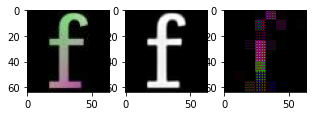


Same Style (Image 2)
SSIM Score = 0.192


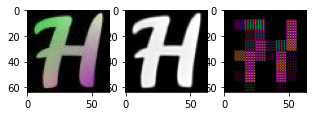


Same Mask (Image 3)
SSIM Score = 0.546


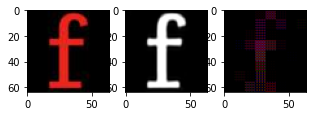


First Image style + Second Image Mask --> Expected Image 2, (Same style different mask)
SSIM Score = 0.192


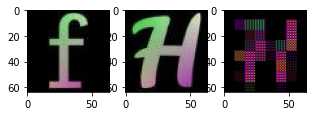


Third Image style + First Image Mask --> Expected Image 3 (Differnet style same mask)
SSIM Score = 0.540


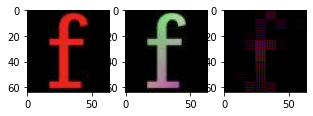

In [ ]:
print("Threshold: -0.45 Learning rate =" ,lr)
#print("Using cosine")
display_all(gt_base_image, out_mask, out_image,
                gt_ss_image, ss_out_mask, ss_out_image,
                gt_sm_image, sm_out_mask, sm_out_image,
                out12_image, out13_image
               )


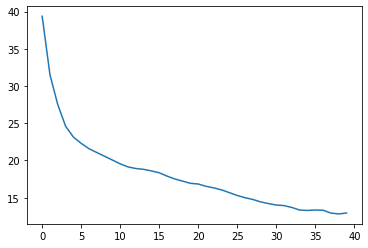

In [ ]:
 
  
  
display_epoch_losses(num_epochs,epoch_losses)

# Save Model

In [ ]:
#@title
torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': total_loss
            }, 'model_weights')

In [ ]:
#@title
model1 = MyModel(enc, dec)
optimizer1 = optim.Adam(model.parameters(), lr=0.001)

checkpoint = torch.load('model_weights')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

model.eval()
# - or -
model.train()

MyModel(
  (enc): encoder(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
    (conv2): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1))
    (conv3): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1))
    (conv1d1): Conv1d(53824, 1024, kernel_size=(1,), stride=(1,))
    (conv1d2): Conv1d(1024, 512, kernel_size=(1,), stride=(1,))
    (conv1d3): Conv1d(512, 256, kernel_size=(1,), stride=(1,))
    (upconv1): ConvTranspose2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (upconv2): ConvTranspose2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (upconv3): ConvTranspose2d(64, 1, kernel_size=(3, 3), stride=(1, 1))
  )
  (dec): decoder(
    (conv1d0): Conv1d(256, 512, kernel_size=(1,), stride=(1,))
    (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1))
    (conv2): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1))
    (conv3): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1))
    (conv1d1): Conv1d(53824, 1024, kernel_size=(1,), stride=(1,))
    (conv1d2): Conv1d(1024, 512,

In [ ]:
#@title
optimizer1.state_dict

<bound method Optimizer.state_dict of Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
)>

# Test


In [ ]:
style_image = "./data10/styles10/100_199/00107.jpg"
mask = "./data10/masks10/00000.jpg"
test(style_image,mask)

error: ignored